In [1]:
% matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import json
import matplotlib.gridspec as gridspec
import copy
import seaborn as sns
from scipy.stats import ttest_1samp
import sys
sys.path.append('..')
from helpers.glove_neighbors import *
from helpers.funcs import *

In [4]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()

In [5]:
#cluster_method = '_relative'
cluster_method = ''

In [20]:
means = np.load(OUTPUT_DIR + 'cluster_' + str(NUM_CLUSTERS) +'_means.npy')
glove = pd.read_csv(OUTPUT_DIR+'glove.50d.csv', sep='\t', index_col=0)

In [8]:
for m in means:
    print(neighbors_vector(m, glove).head(25))
    print('-----')

sensibl            0.485332
regul              0.497323
requir             0.533412
access             0.536257
#gunreformnow      0.541980
abid               0.544173
legisl             0.551507
argument           0.552467
#guncontolnow      0.565462
allow              0.565726
firearm            0.568381
proper             0.572559
fix                0.578653
prevent            0.579407
stricter           0.580735
ownership          0.583617
polici             0.586424
#gunsens           0.587736
illeg              0.590548
rid                0.591611
#enoughisenough    0.591871
background         0.592751
#neveragain        0.595222
common             0.599446
solut              0.600552
dtype: float64
-----
honor          0.324622
candlelight    0.353504
memori         0.363426
vigil          0.381673
tuesday        0.384936
gather         0.397793
honour         0.436819
observ         0.450717
flown          0.456370
oct            0.470578
capitol        0.478775
pm             

In [21]:
cluster_names = {0: "laws & policy",
 1: 'remembrance',
 2: 'ideology',
 3: 'other (slang)',
 4: 'news & investigation',
 5: 'solidarity'}

In [23]:
cluster_words = {}
for i, m in enumerate(means):
    cluster_words[i] = ', '.join(neighbors_vector(m, glove).head(10).index)

In [24]:
cluster_words

{0: 'sensibl, regul, requir, access, #gunreformnow, abid, legisl, argument, #guncontolnow, allow',
 1: 'honor, candlelight, memori, vigil, tuesday, gather, honour, observ, flown, oct',
 2: 'extremist, radic, islamist, ideolog, racist, label, akbar, msm, jihadist, wing',
 3: 'dude, yeah, eat, huh, guess, ain, ass, oh, gonna, unarm',
 4: '#break, custodi, #updat, #breakingnew, fatal, confirm, updat, multipl, accord, unconfirm',
 5: 'affect, senseless, ach, heartbroken, heart, sadden, pray, faculti, #prayer, prayer'}

# topic proportions

In [12]:
cluster_proportions = {i:[] for i in range(NUM_CLUSTERS)}
for event in events:
    topics = pd.read_csv(TWEET_DIR + event + '/' + event + '_kmeans_topics_' + str(NUM_CLUSTERS) + '.csv')
    if cluster_method != '':
        assigned_indices, topics = get_assigned_indices_relative(topics) if cluster_method == '_relative' else get_assigned_indices_absolute(topics)
    labels = topics['topic_0']
    props = np.bincount(labels) / np.sum(np.bincount(labels))
    for i, j in enumerate(props):
        cluster_proportions[i].append(j)

In [13]:
for k, v in cluster_proportions.items():
    print(cluster_names[k], np.mean(v))

laws & policy 0.14919339424201725
remembrance 0.08789077594678478
ideology 0.13337319579187404
other (slang) 0.23550283689170665
news & investigation 0.26305062690026665
solidarity 0.13098917022735065


# topic log odds

In [15]:
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [16]:
event_list = []
log_odds_list = []
topic_list = []
race = []
for event in events:
    print(event)
    event_list.extend([event] * NUM_CLUSTERS)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',usecols=['dem_follows', 'rep_follows'])
    data = get_cluster_assignments(event, data, cluster_method[1:])
    dem, rep = split_party(data)
    dem_total = len(dem)
    rep_total = len(rep)
    
    for i in range(NUM_CLUSTERS):
        dem_cluster = (dem['topic']==i).sum()
        rep_cluster = (rep['topic']==i).sum()
        odds =  np.log((rep_cluster / (rep_total - rep_cluster)) / (dem_cluster / (dem_total - dem_cluster)))
        topic_list.append(cluster_names[i])
        log_odds_list.append(odds)
        race.append(shooter_race[event])
        print(cluster_names[i], 'odds', odds)
        
    print()
    print('------')
    

chattanooga


../helpers/funcs.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['topic'] = topics['topic_0']


laws & policy odds 0.17968599380665862
remembrance odds 0.37256646239864805
ideology odds 0.035261313552384384
other (slang) odds 0.03936685915396847
news & investigation odds -0.1454191877716478
solidarity odds -0.2752686382845591

------
roseburg
laws & policy odds -0.030198945707892624
remembrance odds -0.055501884019633005
ideology odds 0.7959112606634102
other (slang) odds 0.0961197627646744
news & investigation odds 0.10836224860038907
solidarity odds -0.3076186023703327

------
colorado_springs
laws & policy odds -0.16395359774222823
remembrance odds -0.2028890695041566
ideology odds -0.3427686496971035
other (slang) odds -0.14458782548258586
news & investigation odds 0.8499332179220687
solidarity odds -0.003910770744710288

------
san_bernardino
laws & policy odds -0.15365587133825595
remembrance odds -0.22876730731212724
ideology odds 0.64355195071847
other (slang) odds -0.14672622278817524
news & investigation odds -0.0001235550115481332
solidarity odds -0.4905917576591376

-

In [17]:
df = pd.DataFrame.from_dict({'event':event_list, 'topic':topic_list, 'log_odds':log_odds_list, 'race':race})

In [18]:
for i, g in df.groupby('topic'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

ideology
Ttest_1sampResult(statistic=3.0162955050761378, pvalue=0.006820894338005842)
laws & policy
Ttest_1sampResult(statistic=-1.9206970314520284, pvalue=0.06914210827651486)
news & investigation
Ttest_1sampResult(statistic=3.496889273828796, pvalue=0.002271422439887125)
other (slang)
Ttest_1sampResult(statistic=-4.983794799719622, pvalue=7.133937699298207e-05)
remembrance
Ttest_1sampResult(statistic=-0.5589921666248228, pvalue=0.5823728633708503)
solidarity
Ttest_1sampResult(statistic=-5.535090376533093, pvalue=2.035135208968326e-05)


[None, None]

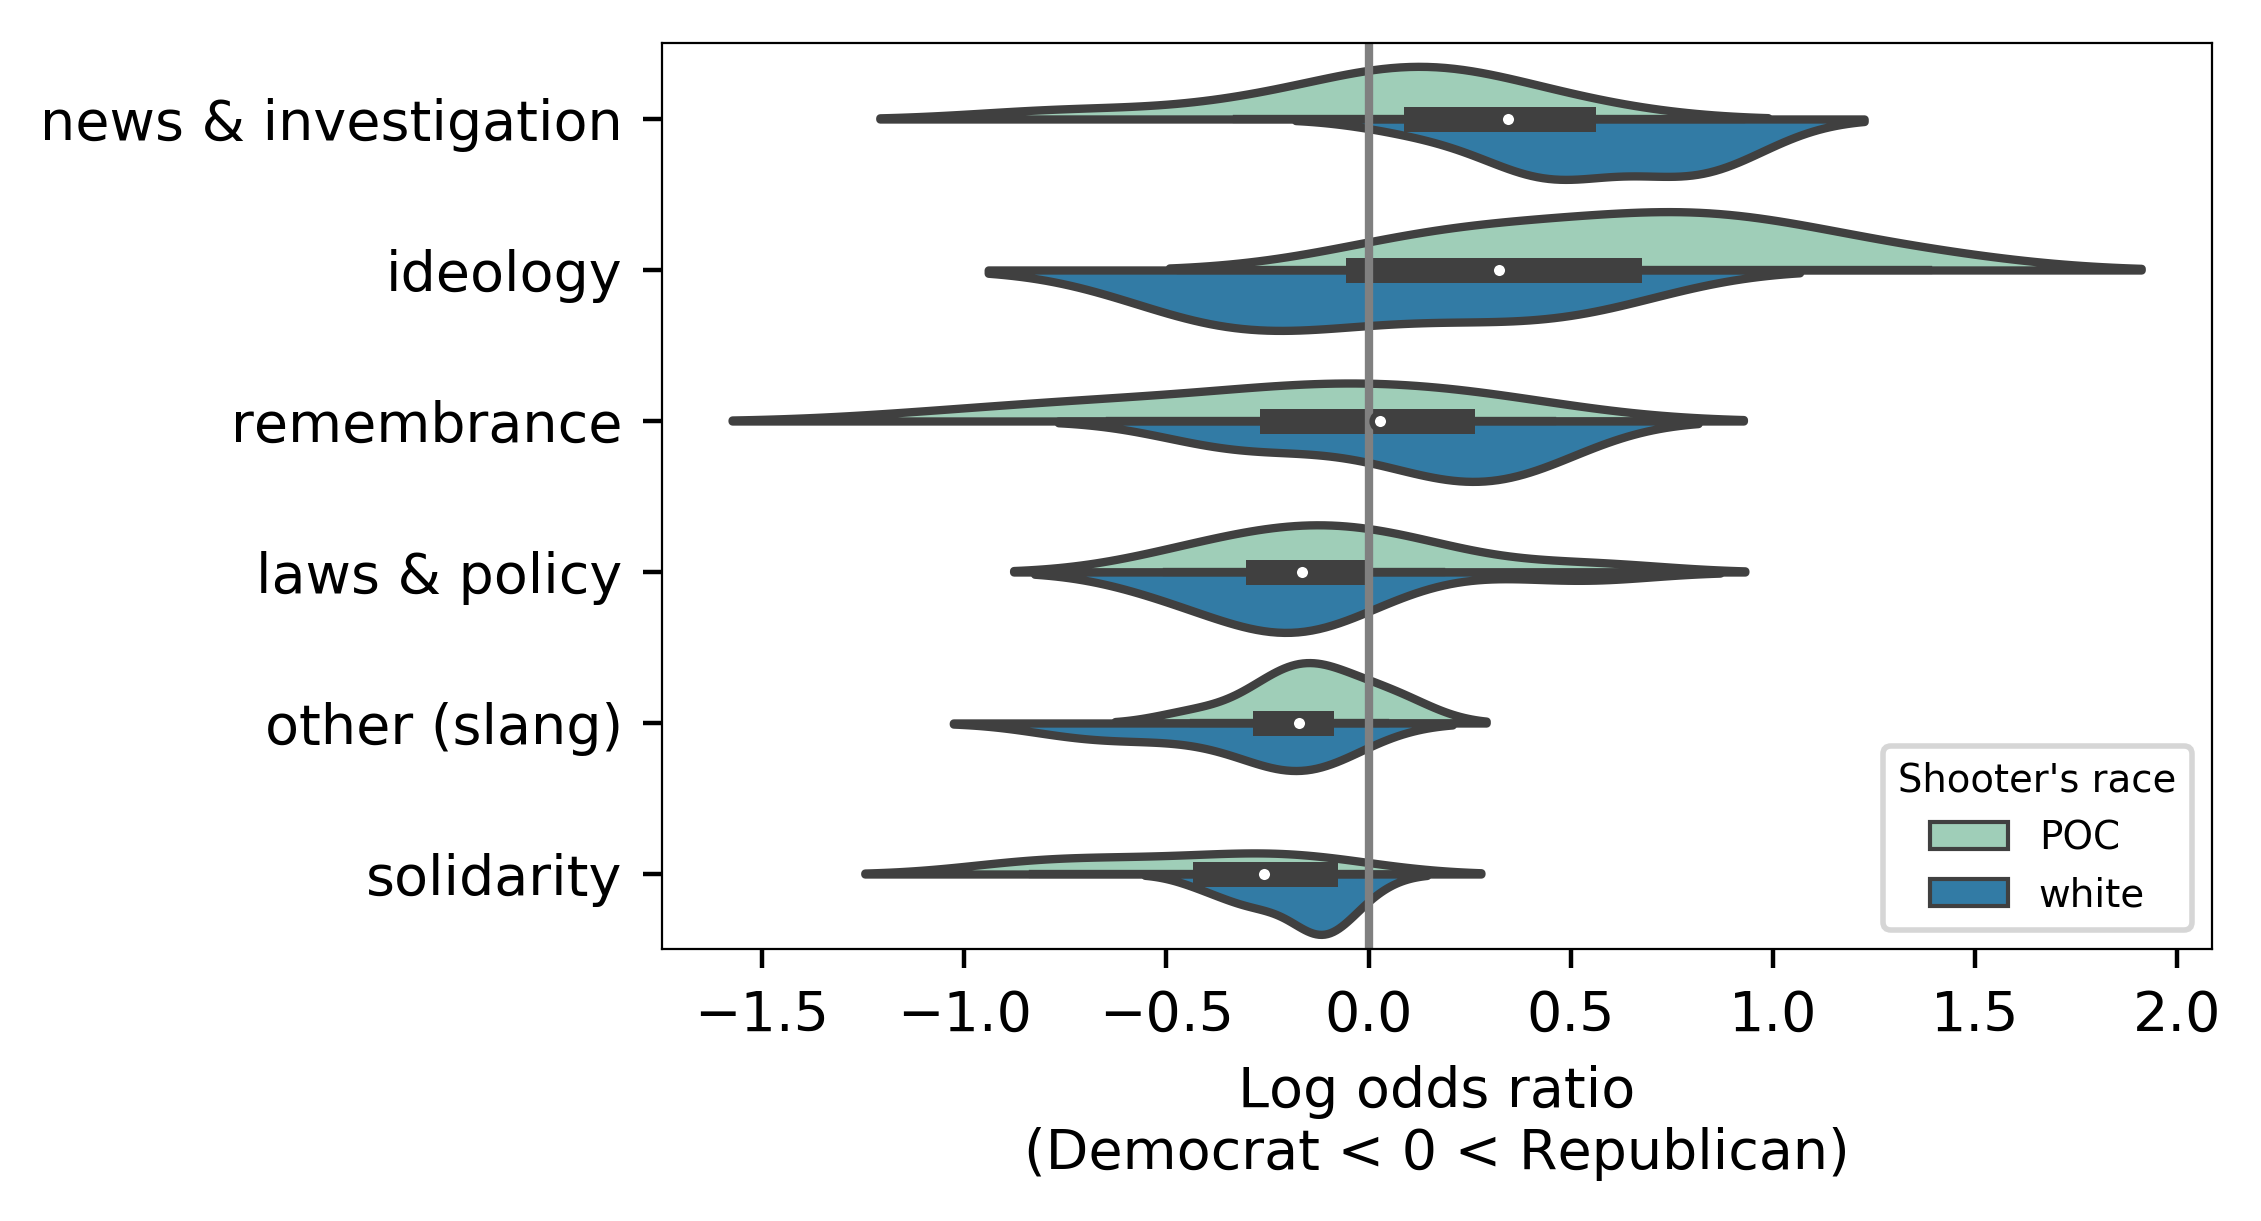

In [19]:
f = plt.figure(dpi=400, edgecolor='grey', figsize=(5,3))
ax = sns.violinplot(data=df, x="log_odds",y="topic", hue='race', split=True, order=reversed(df.groupby('topic').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
plt.axvline(x=0, color='grey')
legend = plt.legend(title="Shooter's race", fontsize=7, loc='lower right')
plt.setp(legend.get_title(),fontsize='x-small')

# plot topic polarization over time

In [37]:
hour = 60 * 60
day = 24 * hour
split_by = 12 * hour
no_splits = int((day / split_by) * 14)  # 14 days

In [48]:
def get_buckets(data, timestamp):
    '''Divide tweets into time buckets.'''
    timestamps = data['timestamp'].astype(float)
    buckets = []
    start = timestamp
    for i in range(no_splits):
        new_start = start + split_by
        b = data[(timestamps > start) & (timestamps < new_start)]
        start = new_start
        buckets.append(b)
    return buckets

In [49]:
def plot_clusters(events):
    '''Plot polarization over time (average value for all the events in params). We only use ["vegas"] in the paper.'''
    num_splits = 18 # 9 days (splits are made ever 12 hours)
    T = (np.arange(num_splits) + 1) / 2 
    freqs = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # topic frequencies
    actual = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # actual leaveout value
    random = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # random leaveout value
    for k, e in enumerate(events):
        pol = json.load(open(TWEET_DIR + e + '/' + e + '_topic_polarization_overtime'+cluster_method+'.json', 'r'))
        for i in range(num_splits):
            for j in range(NUM_CLUSTERS):
                freqs[i, j, k] = int(pol[str(i)][str(j)][2])
                actual[i, j, k] = float(pol[str(i)][str(j)][0])
                random[i, j, k] = float(pol[str(i)][str(j)][1])
            freqs[i, :, k] = freqs[i, :, k] / np.sum(freqs[i, :, k])  # turn frequencies into topic proportions
        
    mean_freqs = np.mean(freqs, axis=2)
    mean_actual = np.mean(actual, axis=2)
    mean_random = np.mean(random, axis=2)
    
    ro = {0:0, 1:2, 2:3, 3:4, 4:1, 5:5}   # order of plots (i.e. topics), order in plot (key): topic_no (value)
    
    row_num = 2
    col_num = 3
    sns.reset_orig()  # get default matplotlib styles back
    clrs = sns.color_palette('husl', n_colors=NUM_CLUSTERS)  # a list of RGB tuples
    
    #fig, ax = plt.subplots(row_num, col_num, dpi=400, sharex='col', sharey='row')
    fig = plt.figure(dpi=600,figsize=(6.7,3))
    outer = gridspec.GridSpec(row_num, col_num, hspace=0.22, wspace=0.08)
    #fig.subplots_adjust(hspace=0.6, wspace=0.1)

    #fig.suptitle('Temporal polarization of topics', y=.93, fontsize=9)
    # axes are in a two-dimensional array, indexed by [row, col]
    for c in range(row_num * col_num):
        cluster = ro[c]
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[c], wspace=0, hspace=.1, height_ratios=[3,1])
        
        for j in range(2):   # the two subplots (polarization and frequency)
            ax = plt.Subplot(fig, inner[j])
            if j == 0:
                ax.set_title(cluster_names[cluster], fontsize=12, y=.95)
                lines = ax.plot(T, mean_actual[:, cluster])  # actual
                lines[0].set_color(clrs[c])
                lines = ax.plot(T, mean_random[:, cluster], '--')  # random
                lines[0].set_color(clrs[c])
                ax.tick_params('y', labelsize=8)
                ax.set_xticks([])
                if c not in [0,3]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                    ax.set_ylabel('Polarization', fontsize=9)
                ax.yaxis.grid(color='gray', alpha=0.3, linewidth=.5)
                ax.set_ylim(.47, .64)   # set the ylims of the polarization plots
            else:
                ax.bar(T, mean_freqs[:, cluster], color='lightgray', width=.45, edgecolor='darkgrey')
                ax.set_ylim(0, .46)
                #ax.set_yticks([])
                if c not in [0,3]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                if c not in [3,4,5]:
                    ax.set_xticks([])
                else:
                    ax.set_xticks(np.array([1,3,5,7, 9])+.25)
                    ax.set_xticklabels([int(t) for t in np.array([1,3,5,7, 9])+.25])
                    ax.tick_params('x', labelsize=9)
                if c == 4:
                    ax.set_xlabel('Day after event', fontsize=10)
                if c in [0, 3]:
                    ax.set_ylabel('Freq.', fontsize=8)
                    
                
            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['top'].set_linewidth(0.5)
            ax.spines['right'].set_linewidth(0.5)
            fig.add_subplot(ax)
    #outer.tight_layout(fig)
    plt.show()

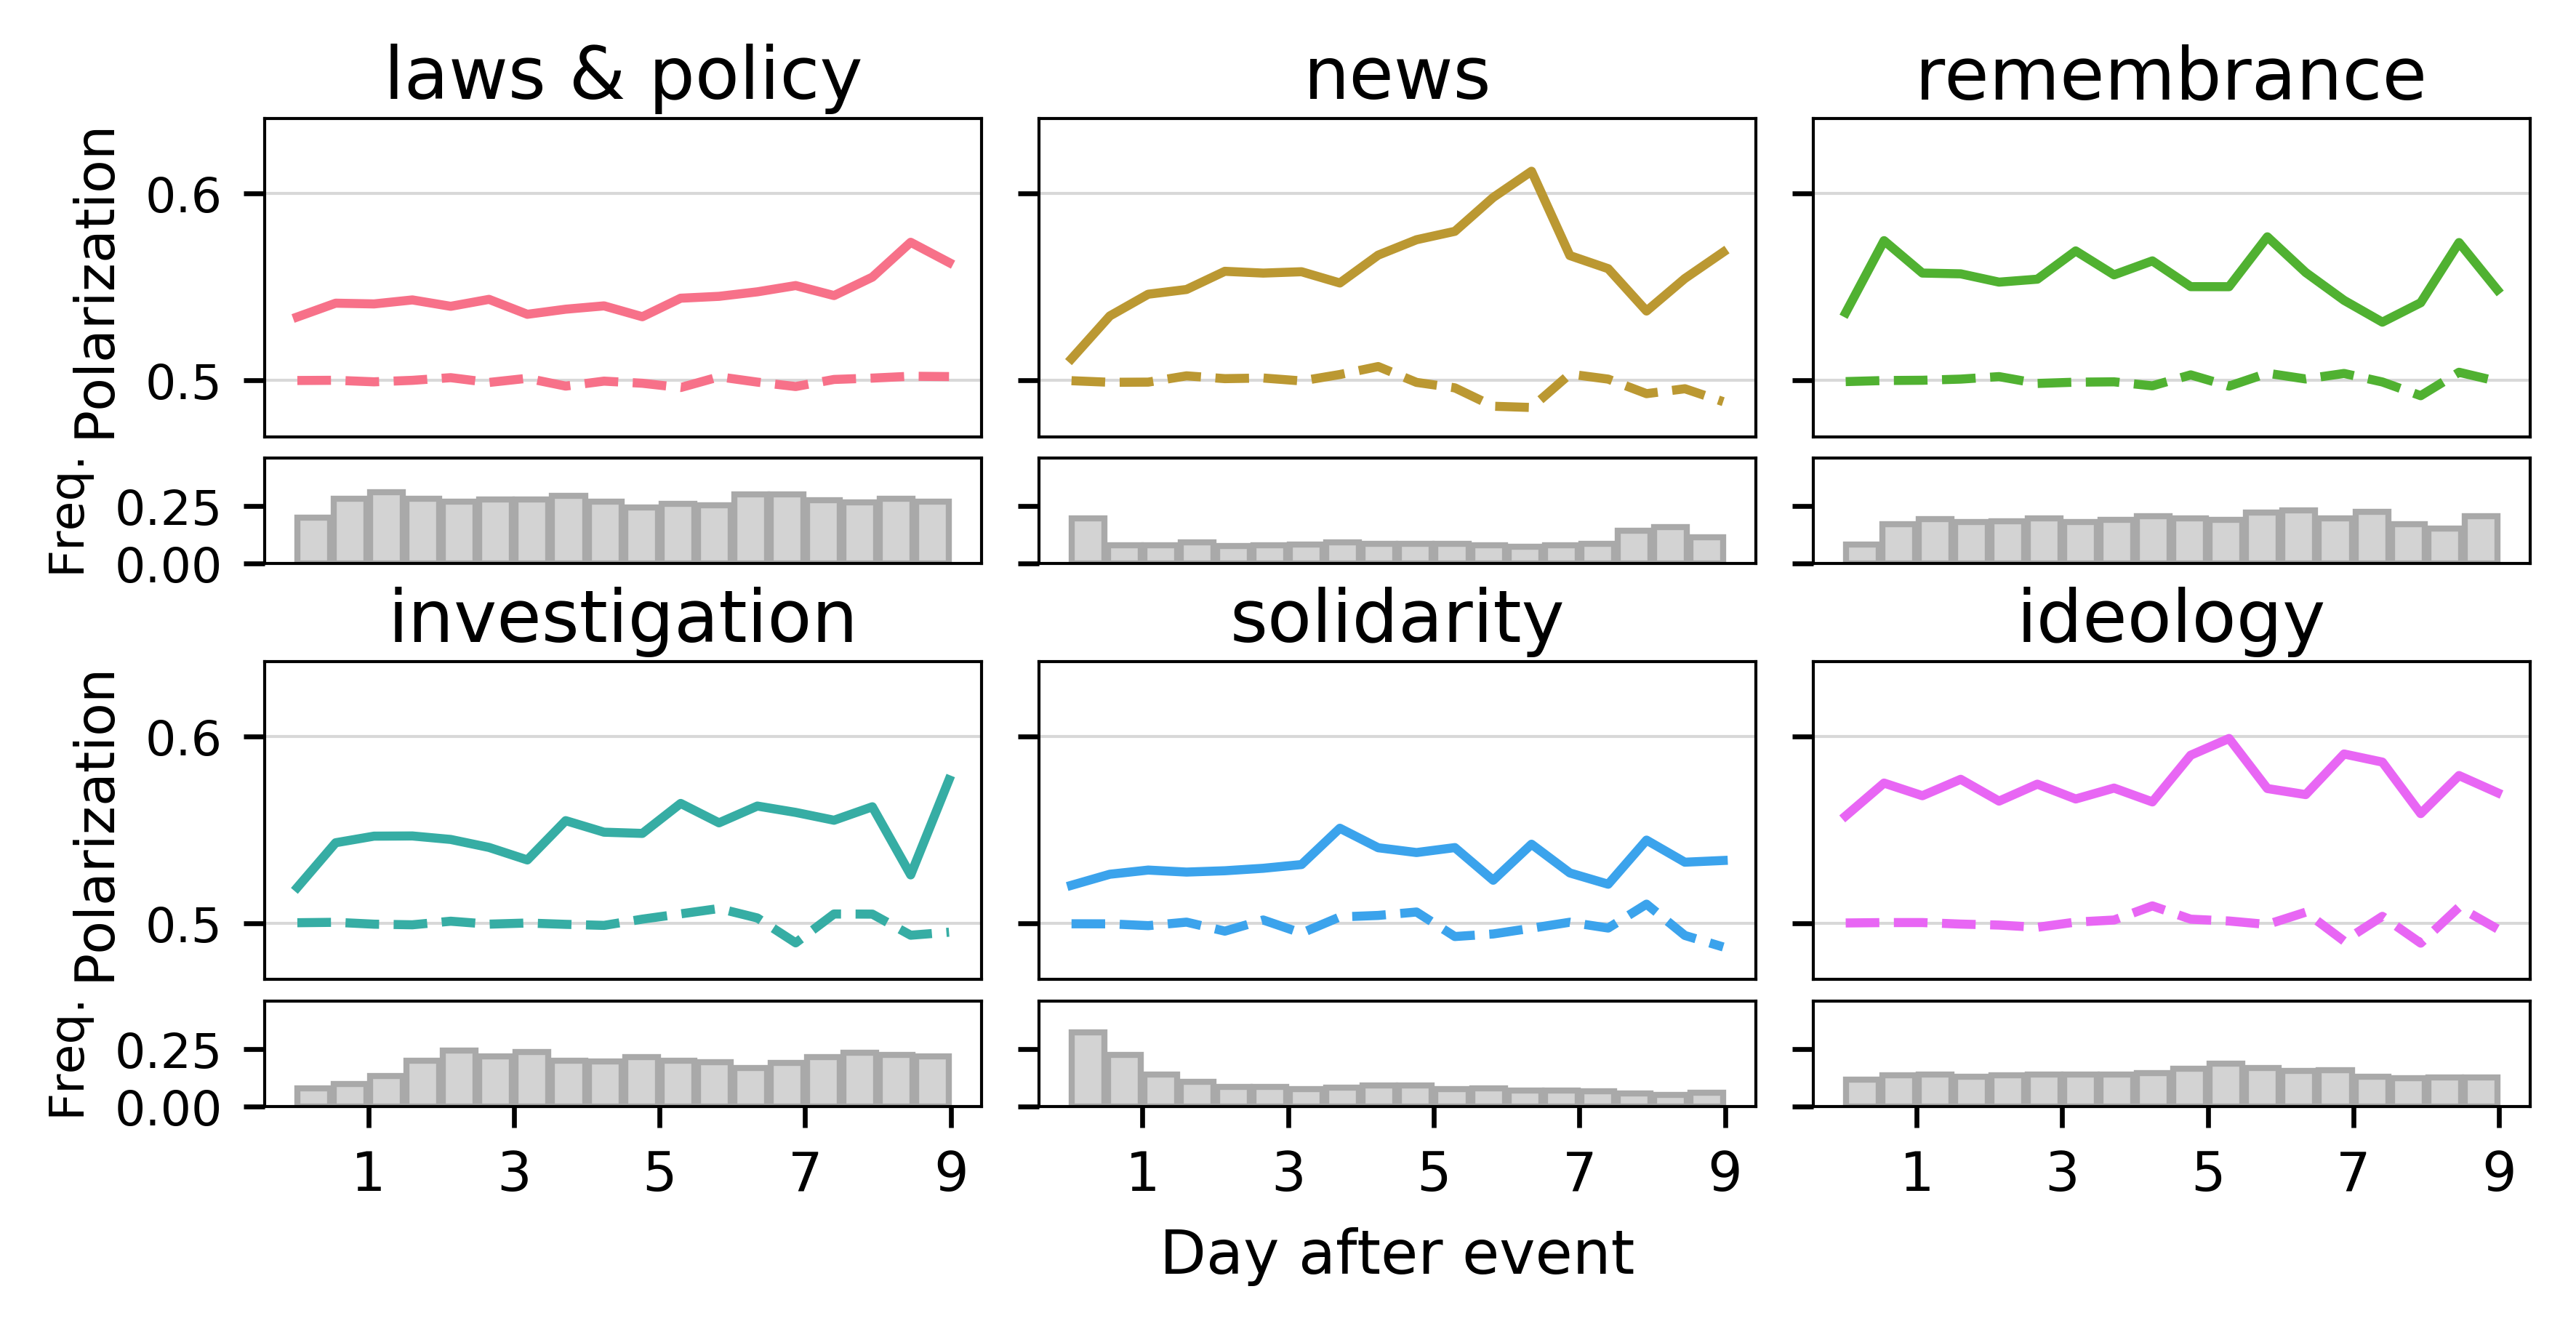

In [57]:
plot_clusters(['vegas'])  # the values from events in the list wil